In [252]:
import pickle
import xgboost as xgb
import itertools

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, auc, roc_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [253]:
%matplotlib inline

In [254]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv', index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим первые 5 строк обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Посморим на размерности обучающей и тестовой выборки

In [255]:
print(train_df.shape)
print(test_df.shape)

(253561, 21)
(82797, 20)


Приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями

In [256]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

<b>y_train</b> - наша целевая переменная    
<b>full_df </b> - объедененная таблица исходных данных (обучающая и тестовая выборки вместе)   
<b>idx_split </b> - индекс, по которому будем отделять обучающую выборку от тестовой  

In [257]:
y_train = train_df['target']

full_df = pd.concat([train_df.drop('target', axis=1), test_df])

idx_split = train_df.shape[0]

In [258]:
sites = ['site%d' % i for i in range(1, 11)]

full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


## Создание признаков

### Извлечение признаков из таблицы сайтов

Посчитаем количество уникальных сайтов в каждой сессии

In [259]:
%%time
unique_count = []
for row in full_sites.values:
    unique = np.unique(row)
    if 0 in unique:
        unique_count.append(len(unique) - 1)
    else:
        unique_count.append(len(unique))
unique_count = np.array(unique_count).reshape(-1,1)

Wall time: 14.2 s


In [260]:
additional_data_df = pd.DataFrame(data = unique_count, columns = ['unique'], index = full_df.index)

Создадим словарь, где ключами будут сайты, а значениями - количество сессий, в которых встречался данный сайт.

In [261]:
site_dict = {}
for row in full_sites.values:
    for site_id in np.unique(row):
        if site_id in site_dict:
            site_dict[site_id] += 1
        else:
            site_dict[site_id] = 1
site_dict.pop(0)

30500

Сделаем индификатор наличия в сессии сайта, входящего в топ 10 популярных сайтов

In [262]:
%%time
top_10 = sorted(list(site_dict.items()), key=lambda tup: tup[1], reverse = True)[:10]
top_10 = [element[0] for element in top_10]
have_top_10 = np.zeros((full_sites.shape[0], 1), dtype = int)
ind = 0
for row in full_sites.values:
    unique = np.unique(row)
    for site_id in unique:
        if site_id in top_10:
           have_top_10[ind] = 1
    ind += 1

Wall time: 11.1 s


In [263]:
additional_data_df['have_top_10'] = have_top_10

Посчитаем число абсолюно уникальных сайтов в сессии (сайты встречались только в этой сессии)

In [264]:
absolutely_unique_count = np.zeros((full_sites.shape[0], 1), dtype = int)
ind = 0
for row in full_sites.values:
    unique = np.unique(row)
    absolutely_unic_row = {}
    for site_id in unique:
        if (site_id != 0) and (site_dict[site_id] == 1) and (site_id not in absolutely_unic_row):
            absolutely_unique_count[ind] += 1
            absolutely_unic_row[site_id] = 1
    ind += 1

In [265]:
additional_data_df['absolutely_unique_count'] = absolutely_unique_count

Сделаем индификатор наличия абсолютно уникального сайта в сессии

In [266]:
absolutely_unique = (absolutely_unique_count > 0).astype(int)

In [267]:
additional_data_df['have_absolutely_unique'] = absolutely_unique

### Работа со временем

Извлекаем таблицу, в которой будут только столбцы времени

In [268]:
time = ['time%d' % i for i in range(1, 11)]

full_time = full_df[time]
full_time.head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
114021,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
146670,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22


Посчитаем время пребываения на каждом сайте в пределах одной сессии

In [269]:
def get_time_diff(row):
    time_length = row.shape[0] - 1
    time_diff = [0] * time_length
    i = 0
    while (i < time_length) and pd.notnull(row[i+1]):
        time_diff[i] = (row[i+1] - row[i]) / np.timedelta64(1, 's')
        i += 1
    return time_diff

In [270]:
%%time
time_diff = []
for row in full_time.values:
    time_diff.append(get_time_diff(row))
time_diff = np.log1p(np.array(time_diff).astype(int))

Wall time: 52.3 s


In [271]:
time_names = ['time_diff' + str(j) for j in range(1,10)]
for ind, column_name in enumerate(time_names):
    additional_data_df[column_name] = time_diff[:, ind]

Посчитаем общее время пребывания на каждой сессии

In [272]:
def get_total_time(row):
    time_length = row.shape[0] - 1
    i = time_length
    while pd.isnull(row[i]):
        i -= 1
    return (row[i] - row[0]) / np.timedelta64(1, 's')

In [273]:
%%time
total_time = []
for row in full_time.values:
    total_time.append(get_total_time(row))
total_time = np.array(total_time).reshape(-1,1).astype(int)

Wall time: 7.48 s


In [274]:
additional_data_df['total_time'] = total_time
additional_data_df['total_time'] = np.log1p(additional_data_df['total_time'].values)

In [275]:
additional_data_df['start_hour'] = full_time['time1'].apply(lambda ts: ts.hour)
additional_data_df['holiday'] =(full_time['time1'].dt.dayofweek >= 5).astype(int)
additional_data_df['day_of_week'] =(full_time['time1'].dt.dayofweek).astype(int)

In [276]:
additional_data_df.head()

,unique,have_top_10,absolutely_unique_count,have_absolutely_unique,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,total_time,start_hour,holiday,day_of_week
session_id,,,,,,,,,,,,,,,,,
21669,2,0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8,1,5
54843,2,0,0,0,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.488294,8,1,5
77292,6,0,0,0,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000,1.609438,8,1,5
114021,5,0,0,0,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147,1.386294,8,1,5
146670,6,0,0,0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000,1.098612,8,1,5


In [277]:
add_data_train = additional_data_df[:idx_split].copy()
add_data_test = additional_data_df[idx_split:]

## Анализ обучающей и тестовой выборок

In [278]:
add_data_train.loc[:,'target'] = y_train

In [279]:
add_data_train.head(3).T

session_id,21669,54843,77292
unique,2.0,2.000000,6.000000
have_top_10,0.0,0.000000,0.000000
absolutely_unique_count,0.0,0.000000,0.000000
have_absolutely_unique,0.0,0.000000,0.000000
time_diff1,0.0,0.000000,0.693147
time_diff2,0.0,7.487174,0.693147
time_diff3,0.0,1.098612,0.000000
time_diff4,0.0,0.000000,0.693147
time_diff5,0.0,0.000000,0.000000
time_diff6,0.0,0.000000,0.000000


In [280]:
dtype_df = add_data_train.dtypes.reset_index()
dtype_df.columns = ['Column_name', 'Column_type']
dtype_df

,Column_name,Column_type
0,unique,int32
1,have_top_10,int32
2,absolutely_unique_count,int32
3,have_absolutely_unique,int32
4,time_diff1,float64
5,time_diff2,float64
6,time_diff3,float64
7,time_diff4,float64
8,time_diff5,float64
9,time_diff6,float64


Все признаки имеют тип int, однако их можно разделить на две группы: категориальные и количественные.

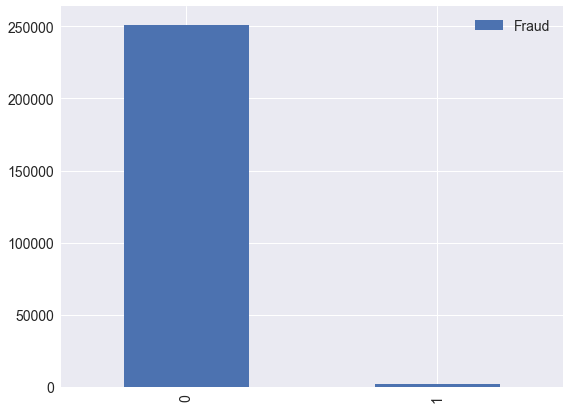

0    251264
1      2297
Name: target, dtype: int64


In [281]:
plt.figure(figsize=(9,7))
add_data_train['target'].value_counts().plot(kind = 'bar', label = 'Fraud')
plt.legend()
plt.show()
print(add_data_train['target'].value_counts())

Как видим, у нас два несбалансированных класса.

Посмотрим на таблицу корреляции датасета

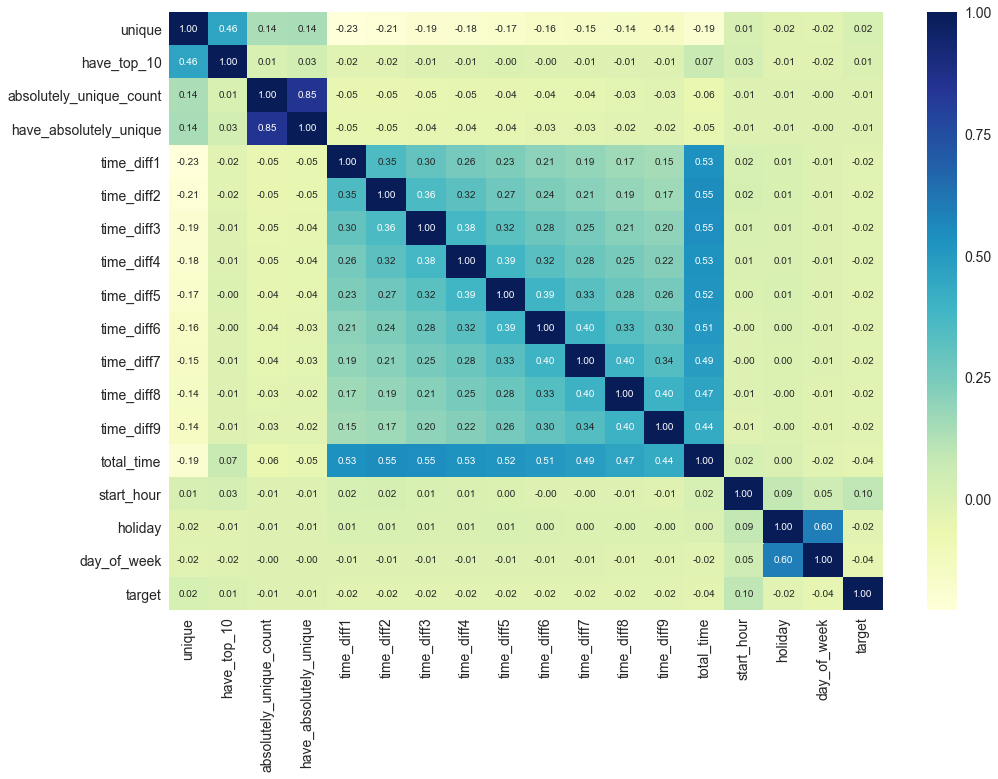

In [282]:
corr = add_data_train.corr()
plt.figure(figsize=(16,11))
sns.heatmap(corr, annot = True, fmt='.2f', cmap="YlGnBu")

Посмотрим на распределения некоторых признаков

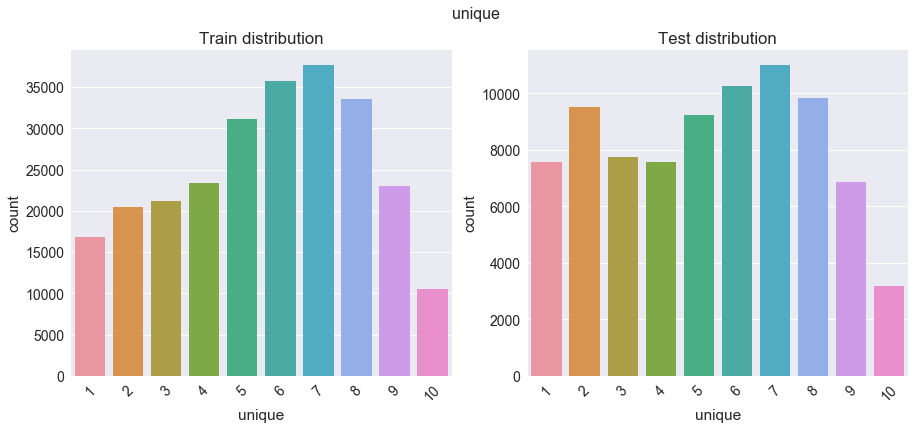

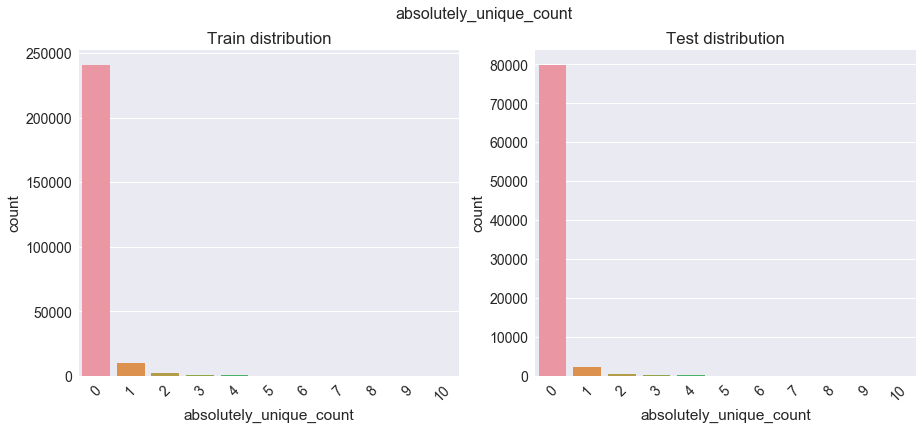

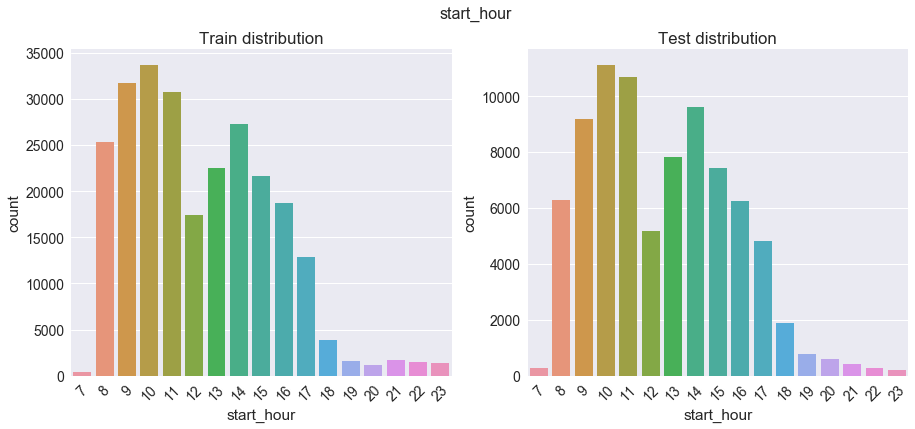

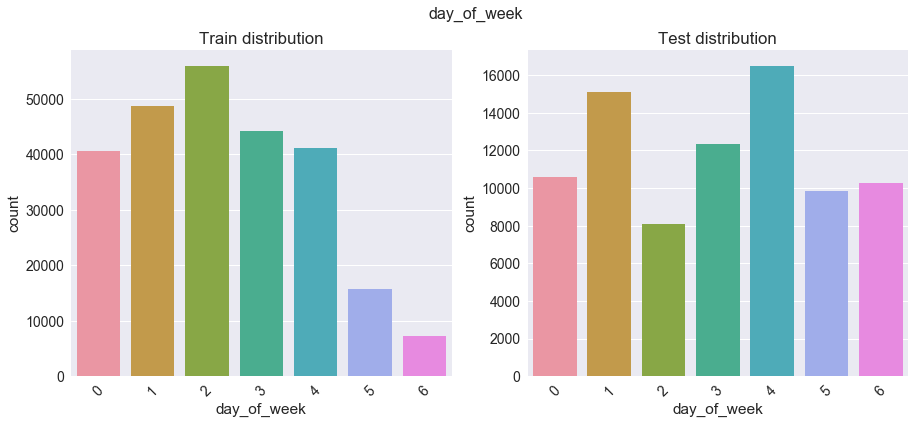

In [283]:
feature_list = ['unique', 'absolutely_unique_count', 'start_hour', 'day_of_week']
for column_name in feature_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle(column_name, fontsize=16)
    sns.countplot(add_data_train[column_name], ax = ax1)
    ax1.set_title("Train distribution")
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)

    sns.countplot(add_data_test[column_name], ax = ax2)
    ax2.set_title("Test distribution")
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

Как видим все признаки распределенны примерно одинаково в обучающей и тестовой выборке.   
Признак start_hour распределен от 7 до 23 часов, а не от 0 до 23 часов, как ожидалось.      

Проведем анализ влияния признаков на целевую переменную

In [284]:
def get_target_dist(column_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle(column_name, fontsize=16)
    sns.countplot(add_data_train[add_data_train['target'] == 1][column_name], ax = ax1)
    ax1.set_title("Fraud count (target: 1)")
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)

    sns.barplot(x= column_name, y="target", data=add_data_train, ax = ax2)
    ax2.set_title("Fraud proportion (target: 1)")
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

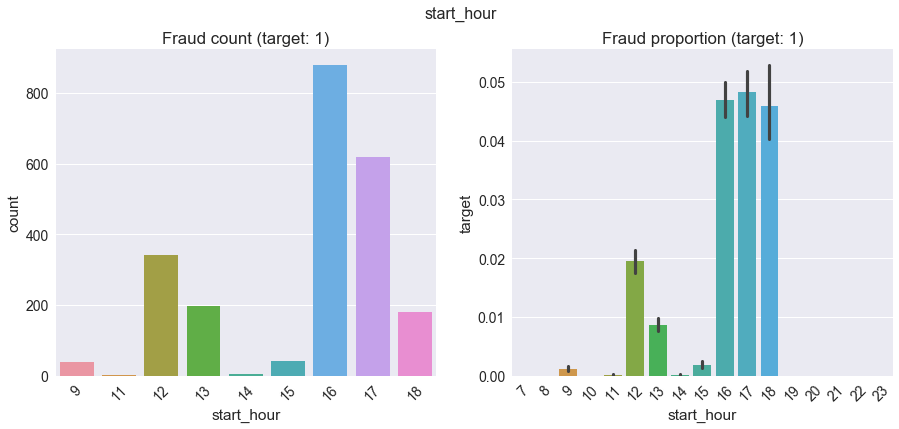

In [285]:
get_target_dist('start_hour')

Мошеничества были зафиксированны в период с 9 до 18 часов, при чем период с 16 по 18 часов больше всего насыщен подозрительной активностью.
На основе этого дополнительно выделим 3 признака:
 - morning: 7 - 11
 - midday: 12 - 15
 - evening: 16 - 18

In [286]:
add_data_train['morning'] = add_data_train['start_hour'].apply(lambda hour: int(hour < 12))
add_data_train['midday'] = add_data_train['start_hour'].apply(lambda hour: int(hour >= 12 and hour < 16))
add_data_train['evening'] = add_data_train['start_hour'].apply(lambda hour: int(hour >= 16 and hour < 19))

add_data_test['morning'] = add_data_test['start_hour'].apply(lambda hour: int(hour < 12))
add_data_test['midday'] = add_data_test['start_hour'].apply(lambda hour: int(hour >= 12 and hour < 16))
add_data_test['evening'] = add_data_test['start_hour'].apply(lambda hour: int(hour >= 16 and hour < 19))

C:\Users\Nikitos\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Nikitos\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Nikitos\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

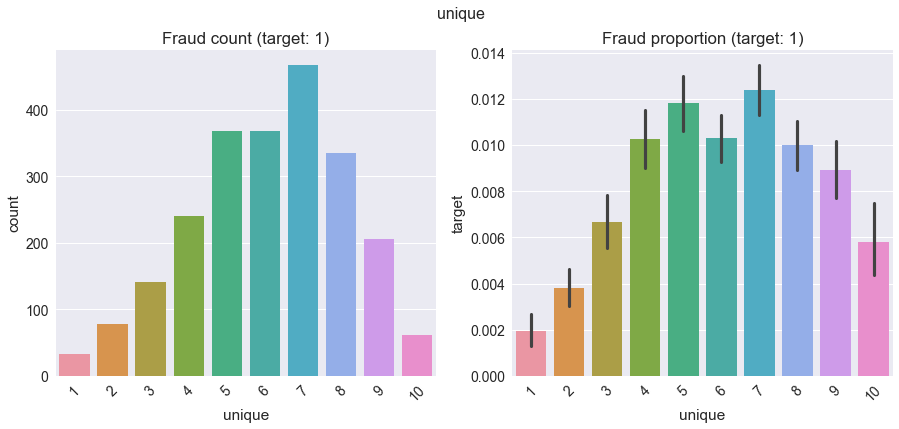

In [287]:
get_target_dist('unique')

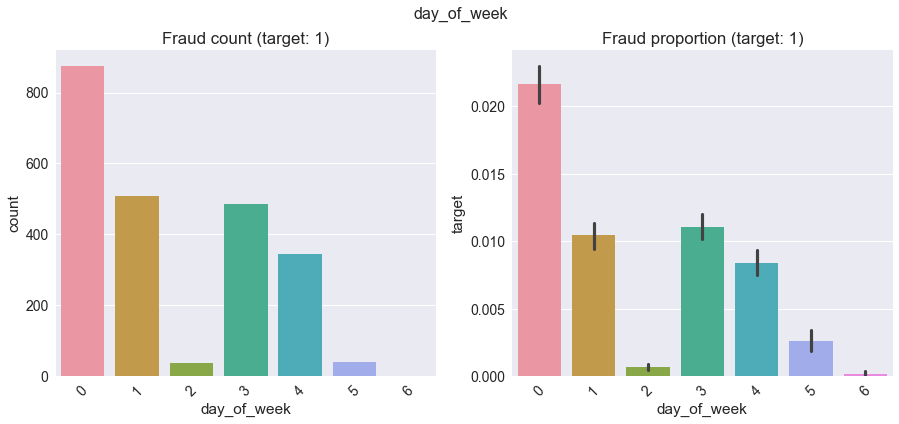

In [288]:
get_target_dist('day_of_week')

Меньше всего подозрительной активности было по средам, субботам и воскресеньям. А вот по понедельникам, наоборот, больше чем в другие дни. 

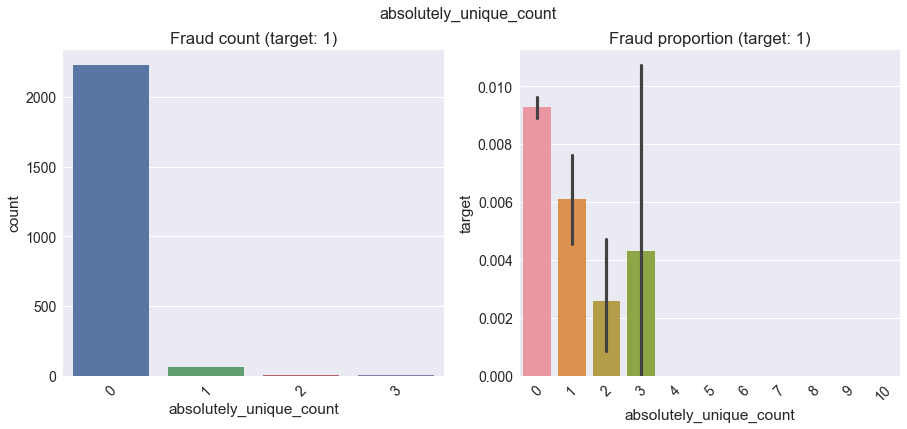

In [289]:
get_target_dist('absolutely_unique_count')

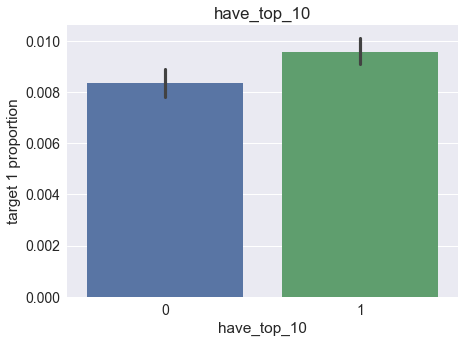

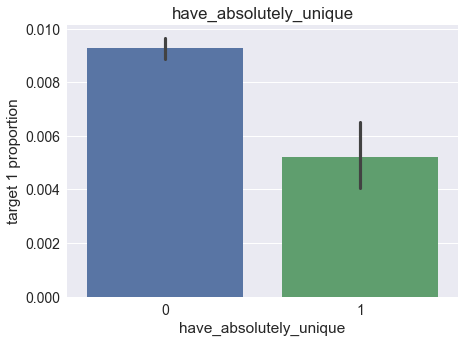

In [290]:
feature_list = ['have_top_10', 'have_absolutely_unique']
for column_name in feature_list:
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x=column_name, y="target", data=add_data_train)
    ax.set(ylabel='target 1 proportion')
    plt.title(column_name)
    plt.show()

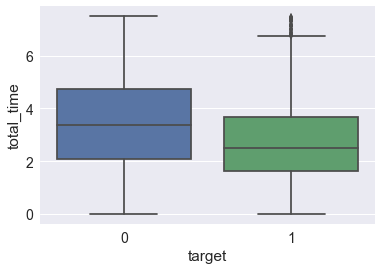

In [291]:
ax = sns.boxplot(x = 'target', y = 'total_time', data = add_data_train)

Продолжительность сессий с подозрительной активностью в среднем меньше, чем у обычных.

Общие наблюдения:
- Наиболее часто подозрительная активность была замечена в период с 16 по 18 часов
- Так же по понедельникам подозрительная активность возникает наиболее часто
- В среднем продолжительность сессий с подозрительной активностью меньше, чем у обычных
- у подозрительных сессий реже встречаются абсолютно уникальные сайты (сайты, которые встречаются лишь один раз за всю историю посещения сайтов)

## Предобработка данных

Преобразуем категориальные переменные в дамми с помощью get_dummies

In [292]:
add_train_dummies = pd.get_dummies(add_data_train, columns = ['start_hour', 'day_of_week'])
add_train_dummies.drop(['target'], axis = 1, inplace = True)
add_test_dummies = pd.get_dummies(add_data_test, columns = ['start_hour', 'day_of_week'])

In [293]:
add_train_dummies.to_csv('project/add_train_dummies.csv')
add_test_dummies.to_csv('project/add_test_dummies.csv')

In [294]:
add_train_dummies = pd.read_csv('project/add_train_dummies.csv', index_col = 'session_id')
add_test_dummies = pd.read_csv('project/add_test_dummies.csv', index_col = 'session_id')
full_sites = pd.read_csv('project/full_sites.csv', index_col = 'session_id')

target = pd.read_csv('project/y_train.csv', header = None)
target.columns = ['session_id', 'target']
target.set_index(['session_id'], inplace = True)
target = target['target']

idx_split = 253561


Для нормализации датасета используем <b>StandardScaler.

In [295]:
names_for_scale = ['time_diff' + str(x) for x in range(1,10)] + ['unique', 'absolutely_unique_count', 'total_time']
scaller = StandardScaler()
for column_name in names_for_scale:
    add_train_dummies[column_name] = scaller.fit_transform(add_train_dummies[column_name].values.reshape(-1,1))
    add_test_dummies[column_name] = scaller.transform(add_test_dummies[column_name].values.reshape(-1,1))

C:\Users\Nikitos\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Создаём разряженную матрицу из матрицы сайтов следующим образом: строки - сессии, столбцы - количесвто вхождений данного сайта в сессию

In [296]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0], 
                                sites_flatten, 
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]
full_sites_sparse.shape

(336358, 48371)

Применяем TF-IDF к разряженной матрице

In [297]:
transformer = TfidfTransformer()
X_train_tf = transformer.fit_transform(X_train_sparse)
X_test_tf = transformer.fit_transform(X_test_sparse)
X_train_tf.shape, X_test_tf.shape

((253561, 48371), (82797, 48371))

Объеденям матрицу сайтов и дополнительные признаки

In [298]:
x_train_full = csr_matrix(hstack([X_train_tf, add_train_dummies.values]))
x_test_full = csr_matrix(hstack([X_test_tf, add_test_dummies.values]))
x_train_full.shape, x_test_full.shape

((253561, 48413), (82797, 48413))

## Выбор метрики

Так как наши классы сильно несбалансированны, то метрика <b>accuracy</b> здесь не подходит.

Будем использовать <b>ROC_AUC</b> в качестве метрики, а так же будем смотреть на результаты <b>confusion_matrix</b>

## Выбор модели

В качестве изначальных моделей рассмотрим следующие:
    - LogisticRegression
    - RandomForestClassifier
    - XGBClassifier    
После отбора модели будем детальнее подбирать параметры выбранной модели

Так как мы имеем исторические данные, взаимосвязанные со временем, стандартная кроссвалидация в данном случае не подойдет. Мы будем применять кросс валидацию с помощью TimeSeriesSplit - техники кросс валидации для временных рядов.   
Её суть заключается в следующем: делим выборку, например, на 5 частей: [1, 2, 3, 4, 5], затем обучаем слудеющим образом
- фолд 1: обучающая [1], тестовая [2]
- фолд 2: обучающая [1, 2], тестовая [3]
- фолд 3: обучающая [1, 2, 3], тестовая [4]
- фолд 4: обучающая [1, 2, 3, 4], тестовая [5]   

Такой подход поможет лучше оценить качество работы алгоритма.

In [299]:
X_train, X_valid, y_train, y_valid = train_test_split(x_train_full, target, test_size = 0.3)
tscv = TimeSeriesSplit(n_splits=5)

In [300]:
%%time
clf_lr = LogisticRegression(random_state=42)
clf_lr.fit(X_train, y_train)
preds_lr = clf_lr.predict_proba(X_valid)[:, 1]
print('Train test split LogisticRegression score: %s ROC AUC' % round(roc_auc_score(y_valid, preds_lr), 4))
cross_score_lr = np.mean(cross_val_score(clf_lr, x_train_full, target, scoring = 'roc_auc', cv=tscv))
print('Cross validation LogisticRegression score: %s ROC AUC' % cross_score_lr)

Train test split LogisticRegression score: 0.9836 ROC AUC
Cross validation LogisticRegression score: 0.937087560061 ROC AUC
Wall time: 39.4 s


Train test split LogisticRegression score: 0.9818 ROC AUC   
Cross validation LogisticRegression score: 0.916788324378 ROC AUC   
Wall time: 53.6 s

LogisticRegression: 0.9786 ROC AUC     
Cross validation LogisticRegression: 0.937086938025 ROC AUC     
Wall time: 53.1 s


In [135]:
%%time
clf_rf = RandomForestClassifier(random_state=42, n_estimators = 30)
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict_proba(X_valid)[:, 1]
print('Train test split RandomForestClassifier score: %s ROC AUC' % round(roc_auc_score(y_valid, preds_rf), 4))
cross_score_rf = np.mean(cross_val_score(clf_rf, x_train_full, target, scoring = 'roc_auc', cv=tscv))
print('Cross validation RandomForestClassifier score: %s ROC AUC' % cross_score_rf)

Train test split LogisticRegression score: 0.9659 ROC AUC
Cross validation LogisticRegression score: 0.825075585119 ROC AUC
Wall time: 11min


In [301]:
%%time
clf_xgb = xgb.XGBClassifier(random_state=42, booster = 'gblinear')
clf_xgb.fit(X_train, y_train)
preds_xgb = clf_xgb.predict_proba(X_valid)[:, 1]
print('Train test split XGBClassifier score: %s ROC AUC' % round(roc_auc_score(y_valid, preds_xgb), 4))
cross_score_xgb = np.mean(cross_val_score(clf_xgb, x_train_full, target, scoring = 'roc_auc', cv=tscv))
print('Cross validation XGBClassifier score: %s ROC AUC' % cross_score_xgb)

Train test split XGBClassifier score: 0.9829 ROC AUC
Cross validation XGBClassifier score: 0.935588319262 ROC AUC
Wall time: 57.9 s


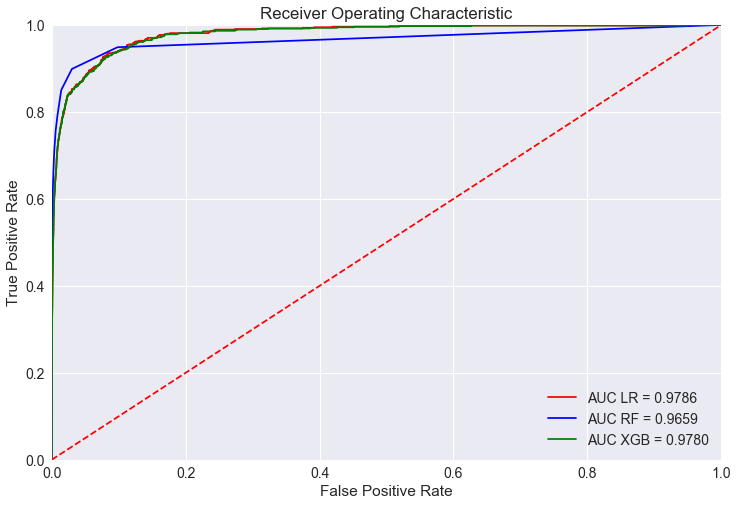

In [148]:
fpr_lr, tpr_lr, threshold = roc_curve(y_valid, preds_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, threshold = roc_curve(y_valid, preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, threshold = roc_curve(y_valid, preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'r', label = 'AUC LR = %0.4f' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC RF = %0.4f' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, 'g', label = 'AUC XGB = %0.4f' % roc_auc_xgb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Как видим, в этой задаче логистическая регрессия справилась немного лучше, поэтому в дальнейшем будем использовать и подбирать параметры этой модели.

Посмотрим на <b>confusion_matrix</b> для ответов логистической регрессии:

In [302]:
def show_confusion_matrix(y_true, y_pred, title = 'Confusion matrix'):
    table = confusion_matrix(y_true.values, y_pred)

    ax = plt.subplot(111, frame_on=False) 
    # fig, ax = plt.subplots(111) 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)

    the_table = plt.table(cellText=table,
        colWidths = [0.5]*len([0, 1]),
        rowLabels=[0,1], colLabels=[0, 1],
        cellLoc = 'center', rowLoc = 'center', loc = "top")

    the_table.set_fontsize(34)
    the_table.scale(1, 4)
    plt.show()

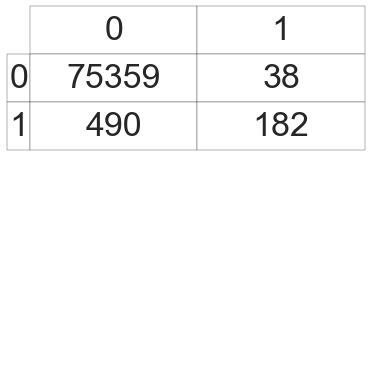

In [303]:
show_confusion_matrix(y_valid, clf_lr.predict(X_valid))

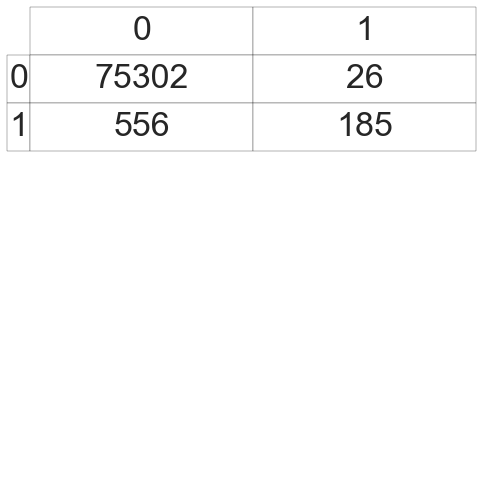

In [151]:
show_confusion_matrix(y_valid, clf_lr.predict(X_valid))

### Подбор параметров модели

Будем перебирать коэффициент при L2 регуляризации и оценивать качество алгоритма с помощью кросс валидации.

In [174]:
def get_best_param(params_space):
    param_range = params_space
    train_scores, test_scores = validation_curve(
        LogisticRegression(), x_train_full, target, param_name="C", param_range=param_range,
        cv=tscv, scoring="roc_auc", n_jobs=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with LogisticRegression")
    plt.xlabel("L2 regularization parameter")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    best_param = params_space[np.argmax(test_scores)]
    print(best_param)

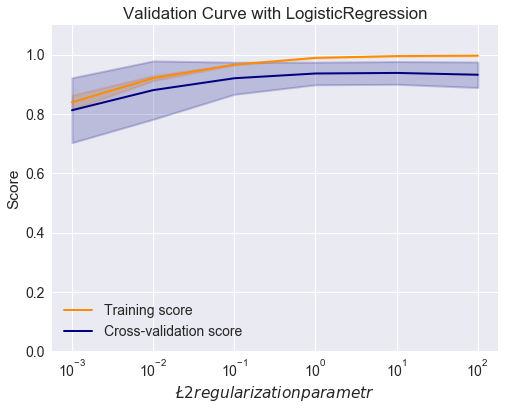

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [175]:
get_best_param(np.logspace(-3, 2, 6))

In [ ]:
get_best_param(np.linspace(1, 10, 7))

0.985249788742


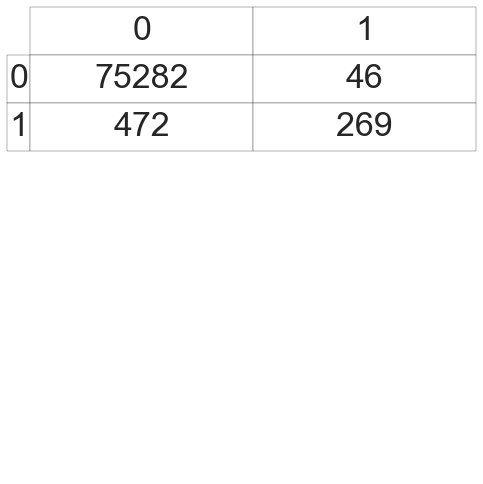

In [184]:
final_model = LogisticRegression(random_state = 42, C = 4)
final_model.fit(X_train, y_train)
print(roc_auc_score(y_valid, final_model.predict_proba(X_valid)[:, 1]))
show_confusion_matrix(y_valid, final_model.predict(X_valid))